In [1]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [4]:
from config import get_configs
from utils import load_data,metric,masked_mse
from dataset import ODDataset
from models import MYMODEL, MYMODEL2, MYMODEL3, MYMODEL4
from lib import train,test

In [5]:
args = get_configs()
# torch.cuda.set_device(1)

In [6]:
args.model_name = "cross_day_week"
args.alpha = 0.4

In [8]:
x, c, te, tc, adj, ac, y = load_data(args)

In [9]:
y.shape

torch.Size([363, 24, 66, 66])

In [10]:

se = torch.Tensor(np.load(args.se_path)).to(args.device)
pe = torch.Tensor(pd.read_csv(args.pe_path,index_col=0).values).to(args.device)

In [11]:
if args.model_name == "vanilla":
    model = MYMODEL(
        s_in_channels=se.size(1),
        p_in_channels=pe.size(1),
        t_in_channels=te.size(2),
        o_in_channels=x.size(3),
        num_nodes=x.size(2),
        in_seq_len=args.in_seq_len,
        out_seq_len=args.out_seq_len,
        num_encoder_layers=args.num_encoder_layers,
        d_model=args.d_model,
        hidden_channels=args.hidden_channels,
        heads=args.heads,
        dropout=args.dropout,
    ).to(args.device)
elif args.model_name == "cross_day":
    model = MYMODEL2(
        s_in_channels=se.size(1),
        p_in_channels=pe.size(1),
        t_in_channels=te.size(2),
        o_in_channels=x.size(3),
        num_nodes=x.size(2),
        in_seq_len=args.in_seq_len,
        out_seq_len=args.out_seq_len,
        num_encoder_layers=args.num_encoder_layers,
        d_model=args.d_model,
        hidden_channels=args.hidden_channels,
        heads=args.heads,
        dropout=args.dropout,
        alpha=args.alpha,
    ).to(args.device)
elif args.model_name == "cross_day_att":
    model = MYMODEL3(
        s_in_channels=se.size(1),
        p_in_channels=pe.size(1),
        t_in_channels=te.size(2),
        o_in_channels=x.size(3),
        num_nodes=x.size(2),
        in_seq_len=args.in_seq_len,
        out_seq_len=args.out_seq_len,
        num_encoder_layers=args.num_encoder_layers,
        d_model=args.d_model,
        hidden_channels=args.hidden_channels,
        heads=args.heads,
        dropout=args.dropout,
    ).to(args.device)
elif args.model_name == "cross_day_week":
        model = MYMODEL4(
            s_in_channels=se.size(1),
            p_in_channels=pe.size(1),
            t_in_channels=te.size(2),
            o_in_channels=x.size(3),
            num_nodes=x.size(2),
            in_seq_len=args.in_seq_len,
            out_seq_len=args.out_seq_len,
            num_encoder_layers=args.num_encoder_layers,
            d_model=args.d_model,
            hidden_channels=args.hidden_channels,
            heads=args.heads,
            dropout=args.dropout,
            alpha = args.alpha
        ).to(args.device)


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 23.70 GiB total capacity; 19.72 MiB already allocated; 3.56 MiB free; 20.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [8]:
criterion = masked_mse

In [9]:
model.parameters()

<generator object Module.parameters at 0x7f54e867a7a0>

In [10]:
# optimizer = optim.Adam(model.parameters(),lr=args.lr)

# scheduler = StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)

In [11]:
# train(model,train_dataloader,se,pe,valid_dataloader,optimizer,criterion,scheduler,args)

In [15]:
x, c, te, tc, adj, ac, y = load_data(args)
    
x_train, x_val, c_train, c_val, adj_train, adj_val, ac_train, ac_val, te_train, te_val, tc_train, tc_val, y_train, y_val = train_test_split(x, c, adj, ac, te, tc, y, test_size=args.test_size, random_state=args.seed)
x_train, x_test, c_train, c_test, adj_train, adj_test, ac_train, ac_test, te_train, te_test, tc_train, tc_test, y_train, y_test = train_test_split(x_train, c_train, adj_train, ac_train, te_train, tc_train, y_train, test_size=args.test_size, random_state=args.seed)

In [17]:
te_train.shape

torch.Size([293, 48, 31])

In [13]:
# seeds = [42, 0, 123, 29, 66]
seeds = [42]
mse_total = rmse_total = mae_total = mape_total = 0

for seed in seeds:
    args.seed = seed
    if args.model_name == "cross_day_week":
        (
            x_train,
            x_valid,
            c_train,
            c_valid,
            adj_train,
            adj_valid,
            ac_train,
            ac_valid,
            te_train,
            te_valid,
            tc_train,
            tc_valid,
            y_train,
            y_valid,
        ) = train_test_split(
            x, c, adj, ac, te, tc, y, test_size=args.test_size, random_state=args.seed
        )
        (
            x_train,
            x_test,
            c_train,
            c_test,
            adj_train,
            adj_test,
            ac_train,
            ac_test,
            te_train,
            te_test,
            tc_train,
            tc_test,
            y_train,
            y_test,
        ) = train_test_split(
            x_train,
            c_train,
            adj_train,
            ac_train,
            te_train,
            tc_train,
            y_train,
            test_size=args.test_size,
            random_state=args.seed,
        )

        train_dataset = ODDataset(
            x_train, c_train, adj_train, ac_train, te_train, tc_train, y_train
        )
        valid_dataset = ODataset(
            x_valid, c_valid, adj_valid, ac_valid, te_valid, tc_valid, y_valid
        )
        test_dataset = ODDataset(
            x_test, c_test, adj_test, ac_test, te_test, tc_test, y_test
        )

        train_dataloader = DataLoader(
            train_dataset, batch_size=args.batch_size, shuffle=False
        )
        valid_dataloader = DataLoader(
            valid_dataset, batch_size=args.batch_size, shuffle=False
        )
        test_dataloader = DataLoader(
            test_dataset, batch_size=args.batch_size, shuffle=False
        )
    else:
        (
            x_train,
            x_valid,
            adj_train,
            adj_valid,
            te_train,
            te_valid,
            y_train,
            y_valid,
        ) = train_test_split(
            x, adj, te, y, test_size=args.test_size, random_state=args.seed
        )
        (
            x_train,
            x_test,
            adj_train,
            adj_test,
            te_train,
            te_test,
            y_train,
            y_test,
        ) = train_test_split(
            x_train,
            adj_train,
            te_train,
            y_train,
            test_size=args.test_size,
            random_state=args.seed,
        )

        train_dataset = ODDataset(x_train, adj_train, te_train, y_train)
        valid_dataset = ODDataset(x_valid, adj_valid, te_valid, y_valid)
        test_dataset = ODDataset(x_test, adj_test, te_test, y_test)

        train_dataloader = DataLoader(
            train_dataset, batch_size=args.batch_size, shuffle=False
        )
        valid_dataloader = DataLoader(
            valid_dataset, batch_size=args.batch_size, shuffle=False
        )
        test_dataloader = DataLoader(
            test_dataset, batch_size=args.batch_size, shuffle=False
        )
    # if seed == 42:
      # model = torch.load(f"{args.model_path}/model_cross_day_0.1_seed_66__epoch_100_batchsize_16_lr_0.0001.pth",map_location='cuda:0').to(args.device)
    # else:
    model = torch.load(f"{args.model_path}/model_{args.model_name}_seed_{args.seed}__epoch_{args.epoch}_batchsize_{args.batch_size}_lr_{args.lr}.pth").to(args.device)
    test_loss,p = test(model,test_dataloader,se,pe,criterion,args)
    y_test = y_test.to(args.device)
    print(torch.count_nonzero(p))
    mse,rmse,mae,mape = metric(p,y_test)
    mse_total += mse
    rmse_total += rmse
    mae_total += mae
    mape_total += mape
mse = mse_total/len(seeds)
rmse = rmse_total/len(seeds)
mae = mae_total/len(seeds)
mape = mape_total/len(seeds)

  

NameError: name 'ODataset' is not defined

In [13]:
mse

2.84527325630188

In [14]:
mape

1.0486454963684082

In [15]:
rmse

1.6867938041687012

In [16]:
mae

0.6504679918289185

In [18]:
p.shape

torch.Size([33, 24, 66, 66])

In [19]:
y_test.shape

torch.Size([33, 24, 66, 66])

In [23]:
p  = p.permute(1,0,2,3)
p_time = torch.mean(p, dim=1)
p_time = torch.mean(p_time, dim=1)
p_time = torch.mean(p_time, dim=1)

In [30]:
y = y_test.permute(1,0,2,3)
y_time =  torch.mean(y, dim=1)
y_time =  torch.mean(y_time, dim=1)
y_time =  torch.mean(y_time, dim=1)

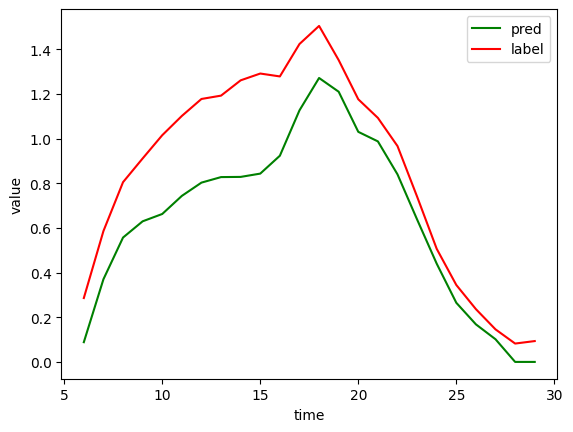

In [37]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


plt.plot(range(6,30), p_time.cpu(), color='green', label='pred')
plt.plot(range(6,30), y_time.cpu(), color='red', label='label')
plt.legend()

plt.xlabel('time')
plt.ylabel('value')
plt.show()

In [38]:
p  = p.permute(2,3,0,1)
p = p.reshape(p.size(0)*p.size(1),p.size(2),p.size(3))
p_node = torch.mean(p, dim=1)
p_node = torch.mean(p_node, dim=1)

In [39]:
y  = y.permute(2,3,0,1)
y = y.reshape(y.size(0)*y.size(1),y.size(2),y.size(3))
y_node = torch.mean(y, dim=1)
y_node = torch.mean(y_node, dim=1)

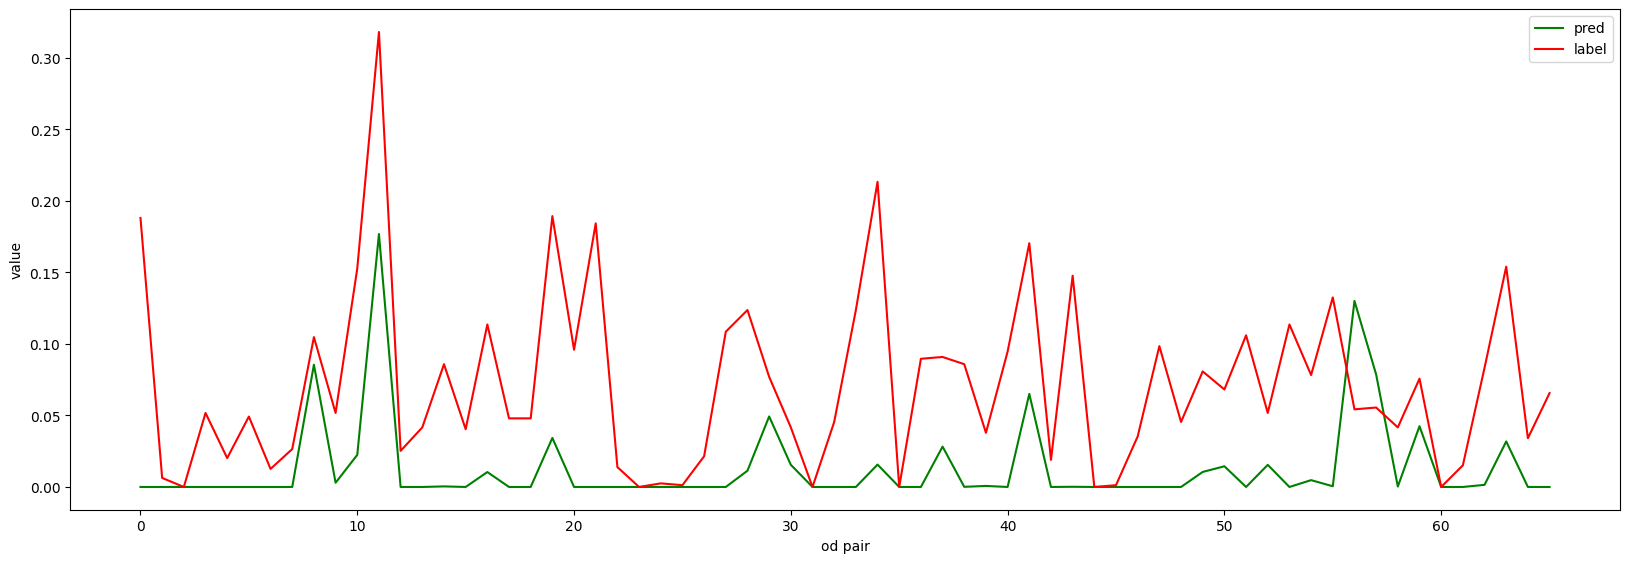

In [43]:
plt.figure(figsize=(20, 6.5))
plt.plot(range(66), p_node[:66].cpu(), color='green', label='pred')
plt.plot(range(66), y_node[:66].cpu(), color='red', label='label')
plt.legend()

plt.xlabel('od pair')
plt.ylabel('value')
plt.show()

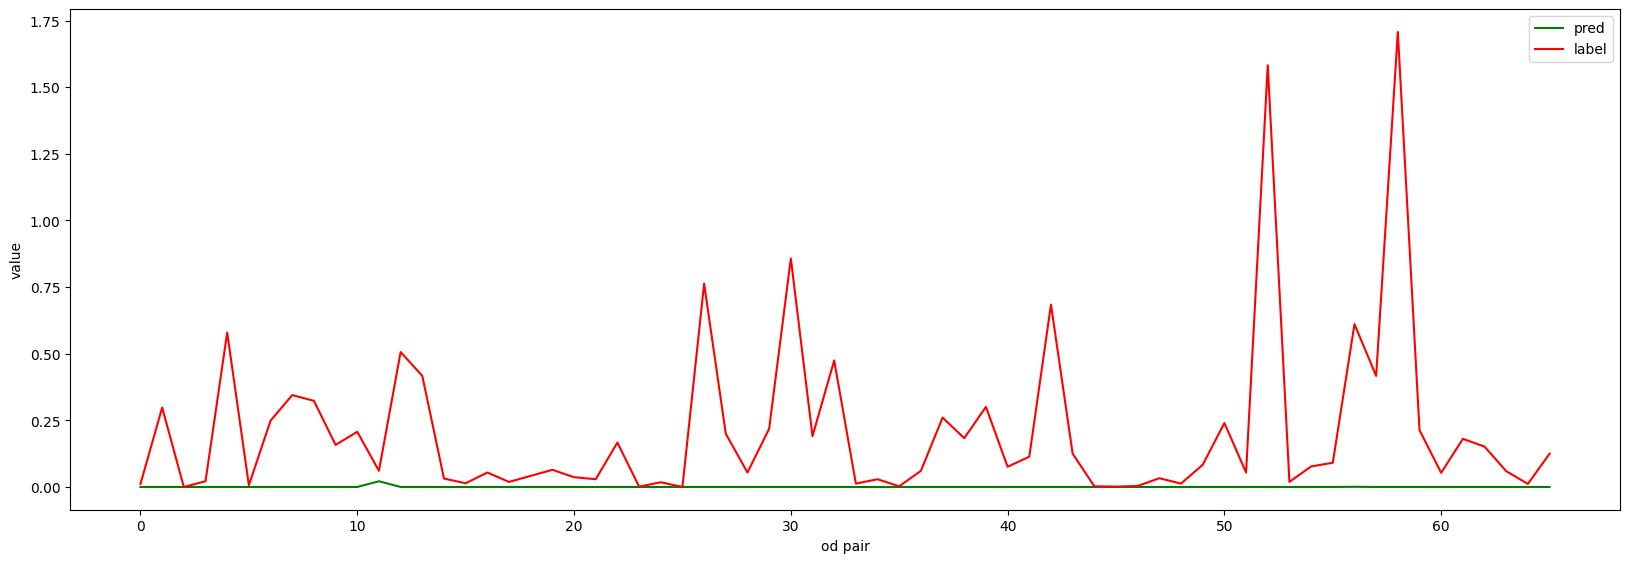

In [44]:
plt.figure(figsize=(20, 6.5))
plt.plot(range(66), p_node[66:132].cpu(), color='green', label='pred')
plt.plot(range(66), y_node[66:132].cpu(), color='red', label='label')
plt.legend()

plt.xlabel('od pair')
plt.ylabel('value')
plt.show()

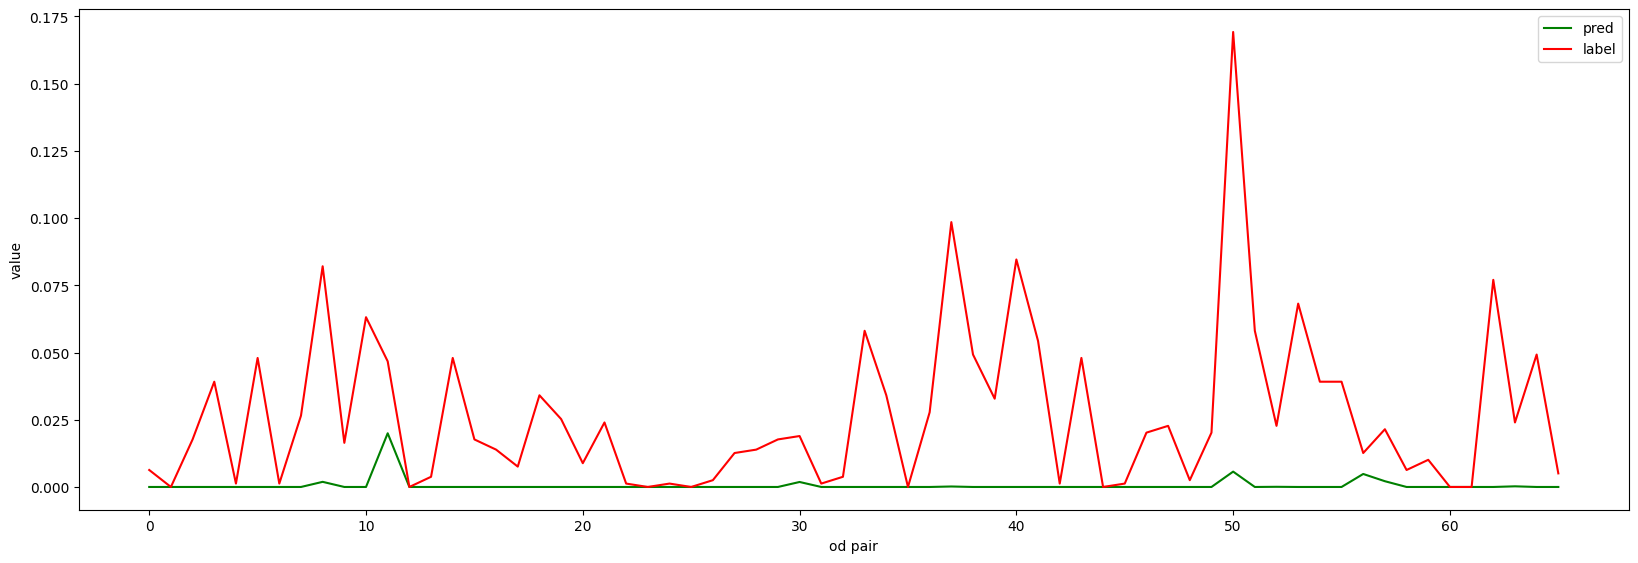

In [45]:
plt.figure(figsize=(20, 6.5))
plt.plot(range(66), p_node[132:198].cpu(), color='green', label='pred')
plt.plot(range(66), y_node[132:198].cpu(), color='red', label='label')
plt.legend()

plt.xlabel('od pair')
plt.ylabel('value')
plt.show()